# <b>Data Exploration</b>
In this notebook we use mediapipe to detect poses of the signers. The results are set of points for every frame for every video.

In [1]:
import pandas as pd
import os
import json
import numpy as np
import cv2
import pickle


In [2]:
working_dir = './'
data_info = pd.read_csv(os.path.join(working_dir,'video_labels.csv'),dtype={'video_id': object})
data_info.head(2)

,bbox,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,29.970030,1280,720,2.50250
1,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,07069,book,23.976024,1280,720,1.25125


In [51]:
# Load landmarks from the pickle file
landmarks = None
try:
    with open(os.path.join(working_dir,'landmarks.pkl'), 'rb') as file:
        landmarks = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, initialize the variable
    print('Could not open landmarks.pkl')
    landmarks = {} # This value contains the landmarks points of all frames, in all the videos
print(len(landmarks.keys()),'out of',len(data_info))

4081 out of 11980


# Data Augmentation

In the subsequent analysis, we shift our focus from the raw images to the associated landmarks. While it's plausible to encounter slight variations in pose estimations from the Mediapipe library, we proceed with the assumption that these differences are negligible. Consequently, we treat the extracted landmarks as constant for our further analyses.

### Augmented data type
One way we augment the data is by moving the landmarks around, not linearly as a group (meaning not by shifting the whole frame to some direction), but rather as subgroup, more specifically, the hands. Different people will wave their hands in different distances from their face, so we can move the hands slighlt lower, higher, sideways in respect to the face.

What we don't want to do is to randomly add a small $\sigma_x,\sigma_y$ to each point, this cause the distortion of the picture and make it unrealistic for a human body.

Other type of augmented data are flipped pictures, we take the $x$ coordinate of the center of the face as reflection axis.

Third type of augmented data are zoomed pictures, we take the center of the frame as given in the bounding box ( given in a columnm, for each video) and push (or pull) al the points away from it.

Lastly, we have an idea that we should test, removing random landmarks points, this data might come in reality when mediapipe fails to find all the points.

### Motivation
Before we jump into augmenting the data, let's understand how it looks like by plotting it.

In [11]:
LANDMARK_GROUPS = {
    "eyes":                 [8, 6, 5, 4, 0, 1, 2, 3, 7],   
    "mouth":                [10, 9],                       
    "right elbow":          [13],
    "right arm":            [11, 15, 17, 19, 15, 21], 
    "right body side":      [11, 23, 25, 27, 29, 31, 27],  
    "left elbow":           [14],  
    "left arm":             [12, 16, 18, 20, 16, 22],  
    "left body side":       [12, 24, 26, 28, 30, 32, 28],  
    "shoulder":             [11, 12],                      
    "waist":                [23, 24],                      
}

In [22]:
# For demonstration purposes we work with a small fraction of the data, say 20 videos
video_ids = list(landmarks.keys())[:20]
landmarks = {key: landmarks[key] for key in video_ids}

#for video_id, pose in landmarks:
    # Do something

In [52]:
key, pose = list(landmarks.items())[19]

In [100]:
# Does not work as expected!!!
'''
import matplotlib.pyplot as plt

# Example coordinates for the pose, replace this with your actual data
pose = np.random.rand(33, 2)  # Replace with your actual pose coordinates

LANDMARK_GROUPS = [
    [8, 6, 5, 4, 0, 1, 2, 3, 7],   # eyes
    [10, 9],                       # mouth
    [11, 13, 15, 17, 19, 15, 21],  # right arm
    [11, 23, 25, 27, 29, 31, 27],  # right body side
    [12, 14, 16, 18, 20, 16, 22],  # left arm
    [12, 24, 26, 28, 30, 32, 28],  # left body side
    [11, 12],                      # shoulder
    [23, 24],                      # waist
]

# Scatter plot
plt.figure(figsize=(8, 8))

for group in LANDMARK_GROUPS:
    group_coordinates = pose[group]
    plt.scatter(group_coordinates[:, 0], group_coordinates[:, 0], label=str(group), s=50)

    # Connect the points in the group
    for i in range(len(group) - 1):
        plt.plot(group_coordinates[i:i+2, 1], group_coordinates[i:i+2, 0], color='gray')

# Add labels and legend
plt.title("Pose Scatter Plot with Connected Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend(title="Landmark Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\n# Example coordinates for the pose, replace this with your actual data\npose = np.random.rand(33, 2)  # Replace with your actual pose coordinates\n\nLANDMARK_GROUPS = [\n    [8, 6, 5, 4, 0, 1, 2, 3, 7],   # eyes\n    [10, 9],                       # mouth\n    [11, 13, 15, 17, 19, 15, 21],  # right arm\n    [11, 23, 25, 27, 29, 31, 27],  # right body side\n    [12, 14, 16, 18, 20, 16, 22],  # left arm\n    [12, 24, 26, 28, 30, 32, 28],  # left body side\n    [11, 12],                      # shoulder\n    [23, 24],                      # waist\n]\n\n# Scatter plot\nplt.figure(figsize=(8, 8))\n\nfor group in LANDMARK_GROUPS:\n    group_coordinates = pose[group]\n    plt.scatter(group_coordinates[:, 0], group_coordinates[:, 0], label=str(group), s=50)\n\n    # Connect the points in the group\n    for i in range(len(group) - 1):\n        plt.plot(group_coordinates[i:i+2, 1], group_coordinates[i:i+2, 0], color=\'gray\')\n\n# Add labels and legend\nplt.t

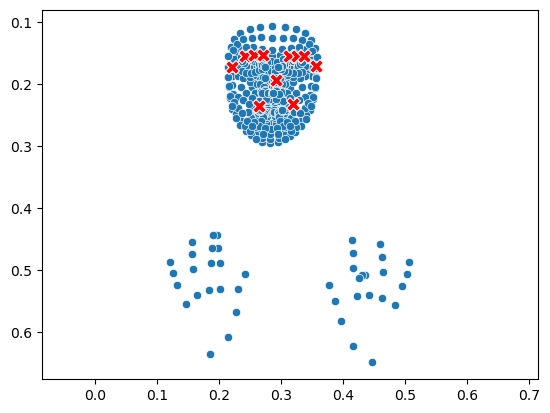

In [59]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

frame = 25 # pick a good frame where all body parts are within it

    
def plot_pose(pose, highlight=[]):
    pose_type = lambda x: [[p[0],p[1]] for p in pose[x]] 
    pose_data = np.array(pose_type('pose')+
                        pose_type('lh')+
                        pose_type('rh')+
                         pose_type('face'))
    sns.scatterplot(x=pose_data[33:,0], y=pose_data[33:,1]) # start after pose values, it shrinks the whole frame
    plt.gca().invert_yaxis()
    if len(highlight)>0:  
        sns.scatterplot(x=pose_data[highlight,0], y=pose_data[highlight,1], color='red', s=100, marker='X')
    plt.axis('equal')

    plt.show()

plot_pose(pose[frame],highlight = LANDMARK_GROUPS['eyes']+LANDMARK_GROUPS['mouth'])


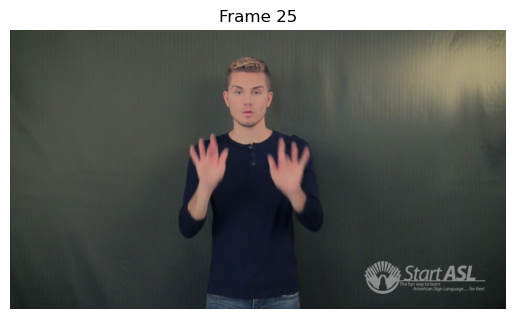

In [94]:
# Code generated by GPT 3.5 to show the same frame as the pose we worked on, for presentation purpose only
import cv2
import matplotlib.pyplot as plt

def plot_frame(video_path, frame_number):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the specified frame number is valid
    if frame_number < 0 or frame_number >= total_frames:
        print(f"Error: Invalid frame number. Must be between 0 and {total_frames - 1}.")
        cap.release()
        return

    # Set the video to the specified frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read frame.")
        cap.release()
        return

    # Display the frame using matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_number}")
    plt.axis('off')
    plt.show()

    # Release the video capture object
    cap.release()

# Example usage: Plot the 25th frame of the video 'vid.mp4'
video_path = os.path.join('videos',key+'.mp4')
frame_number = 25
plot_frame(video_path, frame_number)


### First ugmented type
Moving the hands.

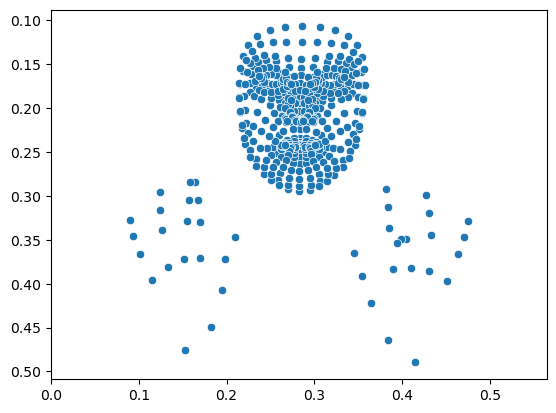

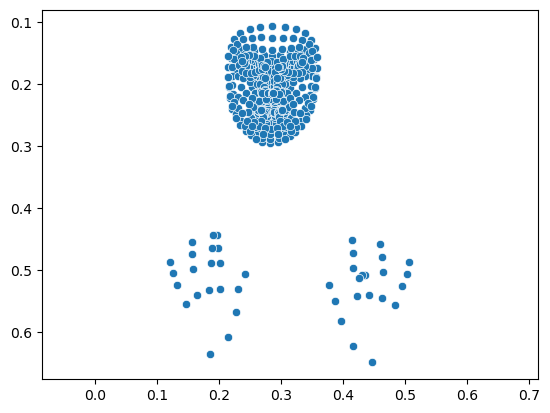

In [60]:
# Load landmarks from the pickle file
landmarks = None
try:
    with open(os.path.join(working_dir,'landmarks.pkl'), 'rb') as file:
        landmarks = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, initialize the variable
    print('Could not open landmarks.pkl')
    landmarks = {} # This value contains the landmarks points of all frames, in all the videos
key, pose = list(landmarks.items())[19]

########################
shift_rate = [7,10,1]# Percents of the total length of the x,y,z axis
                    # These will be generated randomly, in a loop, once we are done with concept testing
new_pose = pose.copy()

frame = new_pose[25].copy()

interval = [frame['pose'][:,i].max()-frame['pose'][:,i].min() for i in range(3)]
shift = [shift_rate[i]*interval[i]/100 for i in range(3)]

plot_pose(frame)
for i in range(3): # Shift for each axis
    frame['pose'][LANDMARK_GROUPS['right arm']+LANDMARK_GROUPS['left arm'],i] += shift[i]
    frame['lh'][:,i] += shift[i]
    frame['rh'][:,i] += shift[i]
plot_pose(frame)
